In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
proj = ccrs.PlateCarree()

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
import fct.fct_plot_claims as fct_plot_claims
from fct.paths import *

path_save_fig = PATH_FIGURE+"sensitivity_cluster_def/"

In [4]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

df_info_storm_FR                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm_FR['storm_landing_date'] = pd.to_datetime(df_info_storm_FR['storm_landing_date'])
df_storm_FR                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm_FR.storm_id.nunique()} number of storms - FR")

########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')

#Load clusters 
cluster_windows = [72, 96, 120]
cluster_radius = [700, None]
radius_key_map = {
    700: 700,
    None: "None"   # ← adapt if your key is named differently
}
df_storm_cluster = {}
df_info_mult_cluster = {}
for windi in cluster_windows : 
    df_storm_cluster[windi] = {}
    df_info_mult_cluster[windi] = {}
    for r_cluster in cluster_radius : 
        rkey = radius_key_map[r_cluster]
        r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
        r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
        fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
#         print(fname_cluster)
        df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
        df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
        df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])
        
        # Save to the dict 
        df_storm_cluster[windi][rkey]     = df_storm_cluster_test
        df_info_mult_cluster[windi][rkey] = df_info_mult_cluster_test

9881 number of storms
4439 number of storms - FR
322 storms with impact


In [5]:
metrics = [
    "Impacting storms in clusters",
    "Claims in clusters",
    "Total cost in clusters"
]

In [6]:
import matplotlib.colors as mcolors

# Base colors per temporal window
window_colors = {
    72: "#d62828", #003049
    96: "#003049", #d62828
    120: "#f77f00"
}

def adjust_lightness(color, amount=1.3):
    """amount > 1 -> lighter, < 1 -> darker"""
    c = mcolors.to_rgb(color)
    return tuple(min(1, x * amount) for x in c)

In [7]:
cluster_windows = [72, 96, 120]
cluster_radius  = [700, None]

data = {metric: [] for metric in metrics}
keys = []

for windi in cluster_windows:
    for r_cluster in cluster_radius:
        rkey = radius_key_map[r_cluster]
        keys.append((windi, rkey))
        
        df_info_clust  = df_info_mult_cluster[windi][rkey]
#         storm_df = df_storm_cluster[windi][rkey]
        sin_df   = sinclim.loc[sinclim.storm_id.isin(df_info_clust.storm_id.unique())]

        # Unique storms in cluster
        pct_cluster = (
            df_info_clust.storm_id.nunique()
            / df_storm_impact.storm_id.nunique()
        ) * 100

        # Claims in clusters
        pct_claims = (
            sin_df.cod_sin.nunique()
            / sinclim.cod_sin.nunique()
        ) * 100

        # Cost in clusters
        total_cost = sinclim["num_chg_brut_cst"].sum()
        cluster_cost = sin_df["num_chg_brut_cst"].sum()
        pct_cost = (cluster_cost / total_cost) * 100 if total_cost else 0

        data["Impacting storms in clusters"].append(pct_cluster)
        data["Claims in clusters"].append(pct_claims)
        data["Total cost in clusters"].append(pct_cost)

In [8]:
index = pd.MultiIndex.from_tuples(
    keys,
    names=["window", "radius"]
)
df_plot = pd.DataFrame(data, index=index)

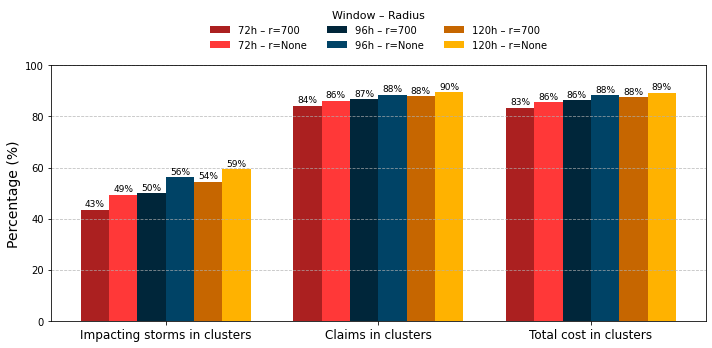

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(metrics))
bar_width = 0.8 / len(keys)

for i, (windi, radius) in enumerate(keys):
    values = df_plot.loc[(windi, radius)].values

    base_color = window_colors[windi]
    color = (
        adjust_lightness(base_color, 0.8) if radius == 700
        else adjust_lightness(base_color, 1.4)
    )

    label = f"{windi}h – r={radius if radius else 'varying'}"

    ax.bar(
        [p + i * bar_width - (len(keys) - 1) * bar_width / 2 for p in x],
        values,
        bar_width,
        color=color,
        label=label
    )

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)", fontsize=14)

# Text labels
for i, key in enumerate(keys):
    for j, v in enumerate(df_plot.loc[key]):
        ax.text(
            j + i * bar_width - (len(keys) - 1) * bar_width / 2,
            v + 0.5,
            f"{v:.0f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

ax.legend(
    title="Window – Radius",
    fontsize=10,
    title_fontsize=11,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=3,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.8)
fig.tight_layout()
fig.savefig(path_save_fig+"perc_summary_clust_def.png", transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(path_save_fig+"perc_summary_clust_def.pdf", format="pdf", transparent=True, dpi=300, bbox_inches='tight')
# fig.savefig(path_save_fig+"perc_summary.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)